### 1) Начало работы, изучим датафрейм, очистим от пропусков и выбросов

In [1]:
# Подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [2]:
# Считываем csv файл с GitHub
df_planets = pd.read_csv(r"https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Planets.csv")
df_planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


In [3]:
# Поссмотрим размерность
df_planets.shape

(1035, 6)

##### Работа с пропусками

In [4]:
# Поссмотрим пропуски
df_planets.isna().sum()

method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

In [5]:
# Заполним все пропуски
np.random.seed(1)
for i in ['orbital_period', 'mass', 'distance']:
    df_planets.loc[df_planets[i].isna(), i] = np.random.uniform(df_planets[i].min(), df_planets[i].max(), df_planets[i].isna().sum())
    #df_planets.loc[df_planets[i].isna(), i] = np.random.seed(df_planets[i].min(), df_planets[i].max(), df_planets[i].isna().sum())
df_planets.isna().sum()     # В итоге все значения заполнены

method            0
number            0
orbital_period    0
mass              0
distance          0
year              0
dtype: int64

##### Работа с дубликатами

In [6]:
# Проверим на дубликаты
df_planets[df_planets.duplicated()]     # Дубликатов нет

,method,number,orbital_period,mass,distance,year


##### Работа с выбросами

In [7]:
# Поиск выбросов по Орбитальному периоду. Возьмем метод через IQR.
lower_bound_op = df_planets['orbital_period'].quantile(0.25) - 1.5*(df_planets['orbital_period'].quantile(0.75) - df_planets['orbital_period'].quantile(0.25))
upper_bound_op = df_planets['orbital_period'].quantile(0.75) + 1.5*(df_planets['orbital_period'].quantile(0.75) - df_planets['orbital_period'].quantile(0.25))
# Поиск выбросов по Массе. Возьмем метод через IQR.
lower_bound_m = df_planets['mass'].quantile(0.25) - 1.5*(df_planets['mass'].quantile(0.75) - df_planets['mass'].quantile(0.25))
upper_bound_m = df_planets['mass'].quantile(0.75) + 1.5*(df_planets['mass'].quantile(0.75) - df_planets['mass'].quantile(0.25))
# Поиск выбросов по Дистанции. Возьмем метод через IQR.
lower_bound_d = df_planets['distance'].quantile(0.25) - 1.5*(df_planets['distance'].quantile(0.75) - df_planets['distance'].quantile(0.25))
upper_bound_d = df_planets['distance'].quantile(0.75) + 1.5*(df_planets['distance'].quantile(0.75) - df_planets['distance'].quantile(0.25))
# Уберем все выбросы
# В новый датафрейм - уберем выбросы по орбитальному периоду
df_pl_perfect = df_planets[((df_planets['orbital_period'] >= lower_bound_op) & (df_planets['orbital_period'] <= upper_bound_op))]
# Берем уже новый датафрейм и в нем уберем выбросы по массе
df_pl_perfect = df_pl_perfect[((df_pl_perfect['mass'] >= lower_bound_m) & (df_pl_perfect['mass'] <= upper_bound_m))]
# Берем новый датафрейм и в нем уберем выбросы по дистанции
df_pl_perfect = df_pl_perfect[((df_pl_perfect['distance'] >= lower_bound_d) & (df_pl_perfect['distance'] <= upper_bound_d))]
df_pl_perfect = df_pl_perfect.reset_index(drop = True)    # Выбросы отсутствуют
df_pl_perfect

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.100000,77.40,2006
1,Radial Velocity,1,874.774000,2.210000,56.95,2008
2,Radial Velocity,1,763.000000,2.600000,19.84,2011
3,Radial Velocity,1,326.030000,19.400000,110.62,2007
4,Radial Velocity,1,516.220000,10.500000,119.47,2009
...,...,...,...,...,...,...
729,Transit,1,3.941507,0.576396,172.00,2006
730,Transit,1,2.615864,12.978789,148.00,2007
731,Transit,1,3.191524,20.250402,174.00,2007
732,Transit,1,4.125083,0.318649,293.00,2008


### 2) Выберем две количественные переменные и найдем для них 95% доверительные интервалы средних значений

In [8]:
# Сделаем отдельный датафрейм со столбцом Орбитальный период
df_op = df_pl_perfect['orbital_period']
# Сделаем отдельный датафрейм со столбцом Дистанция
df_d = df_pl_perfect['distance']

# Уровень доверия
alpha = 0.95

# Вычислим среднее значение ДФ Орбитальный период
mean_op = df_op.mean()
# Вычислим дисперсию значений ДФ Орбитальный период
var_op = df_op.var()
# Вычислим количество значений ДФ Орбитальный период
n_op = df_op.count()

# Вычислим доверительный интервал для среднего значения Орбитального периода
ci_op = stats.norm.interval(confidence = alpha, loc = mean_op, scale = np.sqrt(var_op/n_op))
print(f'95% доверительный интервал для среднего значения Орбитального периода от {ci_op[0].round(2)} до {ci_op[1].round(2)}')

# Вычислим среднее значение ДФ Дистанция
mean_d = df_d.mean()
# Вычислим дисперсию значений ДФ Дистанция
var_d = df_d.var()
# Вычислим количество значений ДФ Дистанция
n_d = df_d.count()

# Вычислим доверительный интервал для среднего значения Дистанции
ci_d = stats.norm.interval(confidence = alpha, loc = mean_d, scale = np.sqrt(var_d/n_d))
print(f'95% доверительный интервал для среднего значения Дистанции от {ci_d[0].round(2)} до {ci_d[1].round(2)}')

95% доверительный интервал для среднего значения Орбитального периода от 220.6 до 275.0
95% доверительный интервал для среднего значения Дистанции от 249.84 до 316.93


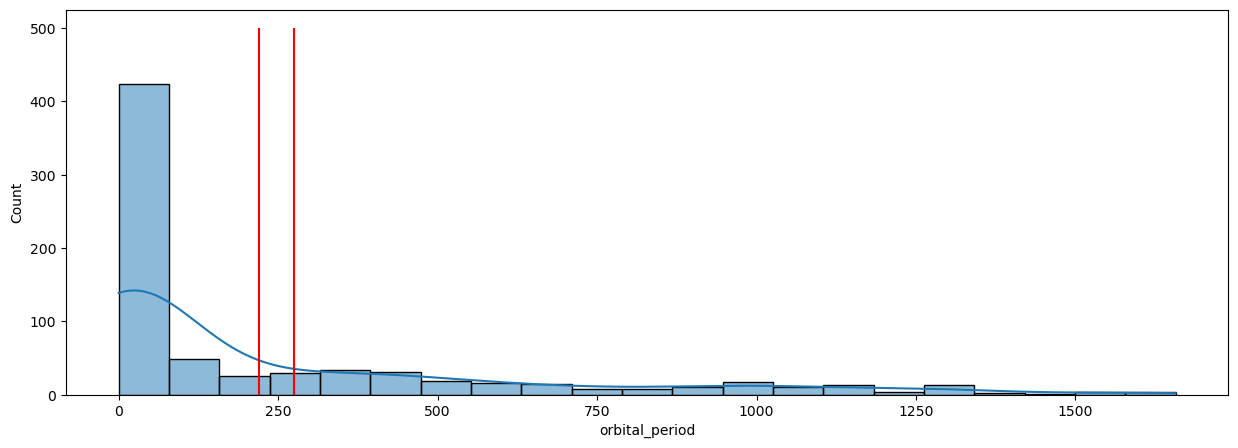

In [9]:
# Выделим доверительный интервал для среднего значения Орбитального периода на гистограмму
plt.figure(figsize = (15,5))
sns.histplot(df_op, kde = True)
plt.vlines(x = ci_op[0], ymin = 0, ymax = 500, color = 'r')
plt.vlines(x = ci_op[1], ymin = 0, ymax = 500, color = 'r')
plt.show()

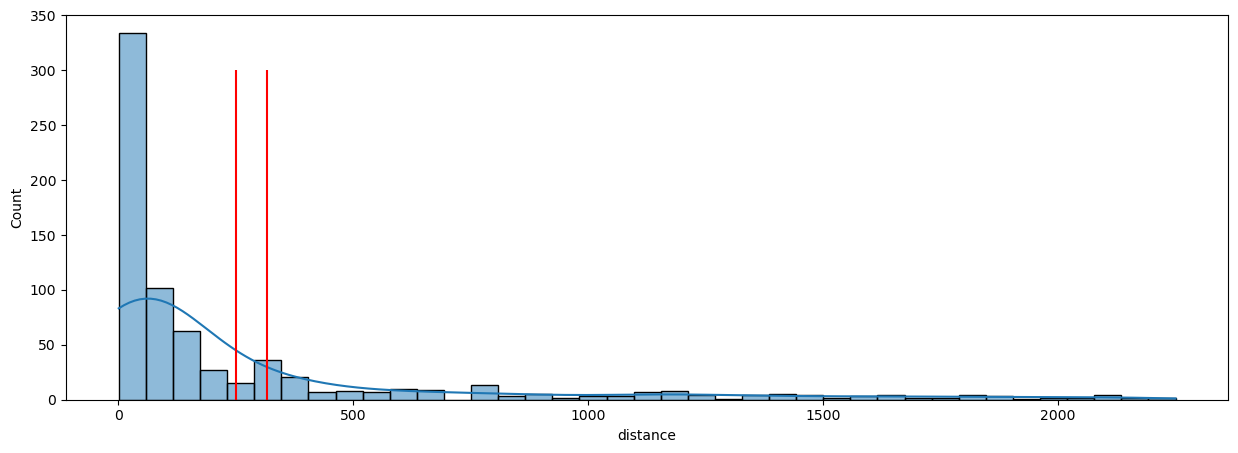

In [10]:
# Выделим доверительный интервал для среднего значения Дистанции на гистограмму
plt.figure(figsize = (15,5))
sns.histplot(df_d, kde = True)
plt.vlines(x = ci_d[0], ymin = 0, ymax = 300, color = 'r')
plt.vlines(x = ci_d[1], ymin = 0, ymax = 300, color = 'r')
plt.show()

##### C 95% вероятностью в рассчитанном интервале (220,6-275,00) лежит реальное среднее значение Орбитального периода, и лишь в 5% случаев мы ошибаемся.
##### C 95% вероятностью в рассчитанном интервале (249,84-316,93) лежит реальное среднее значение Дистанции, и лишь в 5% случаев мы ошибаемся. 

### 3) Оценим распределение переменных на нормальность с помощью формальных тестов и с помощью альтернативных методов

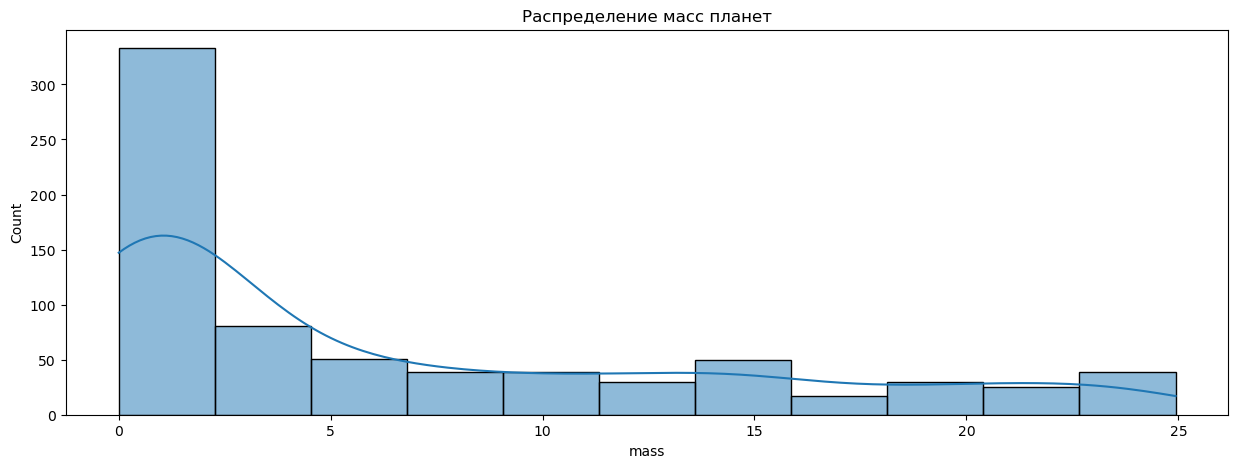

In [11]:
# Построим гистограмму распределения Масс планет
df_m = df_pl_perfect['mass']
plt.figure(figsize = (15,5))
plt.title('Распределение масс планет')
sns.histplot(df_m, kde = True)
plt.show()

##### Тест Шапиро-Уилка

In [12]:
stats.shapiro(df_m)

ShapiroResult(statistic=0.820161261813967, pvalue=7.3075025671880945e-28)

Нулевая гипотеза - распределение нормальное. В нашем тесте p-значение очень маленькое, то есть нулевая гипотеза отвергается, и распределение масс планет нельзя считать нормальным.

##### Тест Андерсона-Дарлинга

In [13]:
stats.anderson(df_m, dist='norm')

AndersonResult(statistic=49.77665702180775, critical_values=array([0.573, 0.652, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=6.710860636590019, scale=7.517747984205541)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Нулевая гипотеза - распределение нормальное.
Для уровня значимости 0,05 критическое значение составляет 0,783, а наблюдаемое значение 49.77. Наблюдаемая статистика гораздо выше критического значения, то есть нулевая гипотеза отвергается, и распределение масс планет нельзя считать нормальным.

##### Тест Колмогорова-Смирнова

In [14]:
stats.kstest(df_m, stats.norm.cdf)

KstestResult(statistic=0.5640904829933717, pvalue=6.544116658966798e-221, statistic_location=1.79, statistic_sign=-1)

В нашем тесте р-значение является очень низким, то есть нулевая гипотеза отвергается, и распределение масс планет нельзя считать нормальным.

##### По итогам трех формальных тестов получаем одинаковый результат: во всех трех тестах нулевые гипотезы отвергаются, это говорит о том, что распределение масс планет нельзя считать нормальным. Это прекрасно видно и на построеной гистограмме распределения масс планет.

In [15]:
# Используем альтернативные методы тестирования на нормальность распределения Масс планет

# Сделаем отдельный датафрейм со столбцом Масса по данным до 2009 года включительно
df_m1 = df_pl_perfect.loc[df_pl_perfect['year'] <= 2009, 'mass']
#df_m1 = df_pl_perfect.loc[(df_pl_perfect['year'] <= 2009)&(df_pl_perfect['mass'] <= 0.05), 'mass']

# Сделаем отдельный датафрейм со столбцом Масса по данным с 2009 года
df_m2 = df_pl_perfect.loc[df_pl_perfect['year'] > 2009, 'mass']

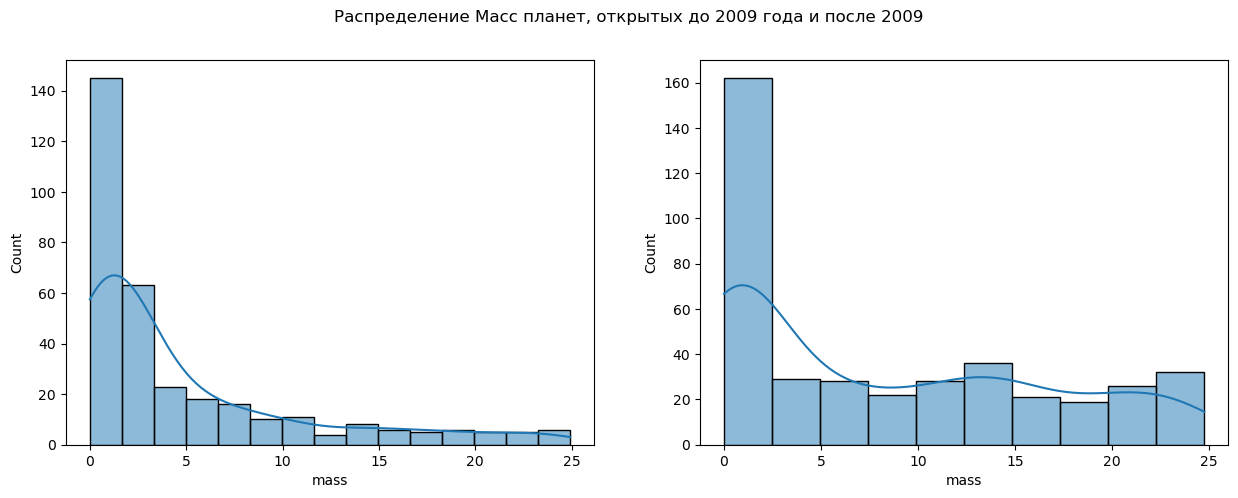

In [16]:
fig, ax  = plt.subplots(1,2, figsize = (15,5))
plt.suptitle('Распределение Масс планет, открытых до 2009 года и после 2009')
sns.histplot(df_m1, kde = True, ax = ax[0])
sns.histplot(df_m2, kde = True, ax = ax[1])
plt.show()

In [17]:
# По Массам планет, открытых до 2009 года включительно
print('Средняя: ', df_m1.mean())
print('Медиана: ', df_m1.median())
print('Скошенность: ', stats.skew(df_m1))
print('Эксцесс: ', stats.kurtosis(df_m1))

Средняя:  4.790709276774917
Медиана:  2.1
Скошенность:  1.6723568710827599
Эксцесс:  1.8843576684838625


In [18]:
# По Массам планет, открытых после 2009 года
print('Средняя: ', df_m2.mean())
print('Медиана: ', df_m2.median())
print('Скошенность: ', stats.skew(df_m2))
print('Эксцесс: ', stats.kurtosis(df_m2))

Средняя:  8.287957659167683
Медиана:  5.84441228287999
Скошенность:  0.5665321148761565
Эксцесс:  -1.096226325256158


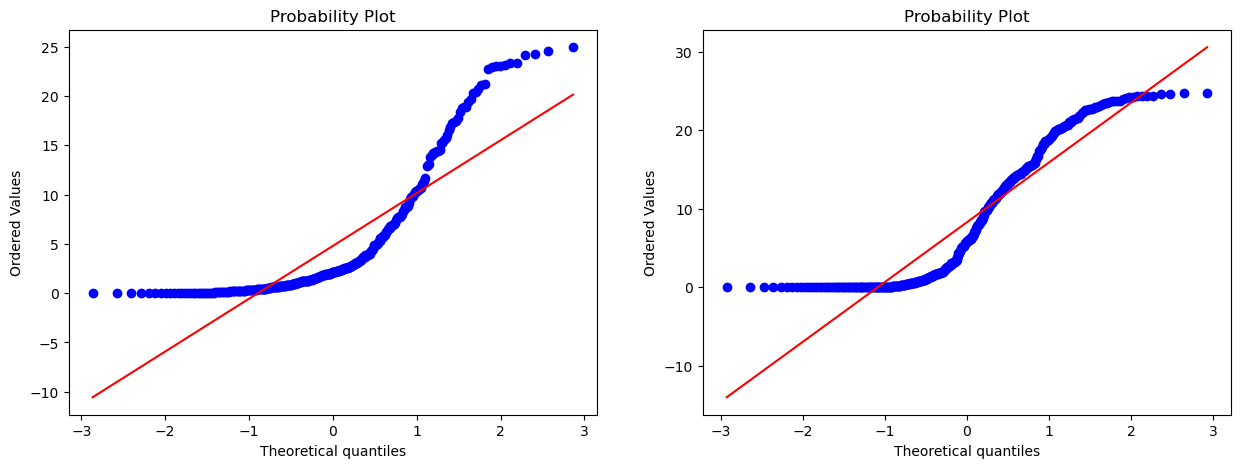

In [19]:
fig, ax  = plt.subplots(1,2, figsize = (15,5))
stats.probplot(df_m1, dist="norm", plot = ax[0])
stats.probplot(df_m2, dist="norm", plot = ax[1])
plt.show()

##### Гистограммы распределения совсем не "колокольчики", они не симметричные, соответственно распределения Масс планет, открытых до 2009 года и после, не являются нормальными.
##### По планетам, открытым до 2009 года включительно: средняя масса - 4.79, медиана - 2.1 (ушла влево, так как там больше значений), скошенность - 1.67 (положительная, имеет длинный хвост справа), эксцесс - 1.88 (положительный, выбросы в данных интенсивнее, чем для нормального распределения).
##### По планетам, открытым после 2009 года: средняя масса - 8.29, медиана - 5.84 (ушла влево, так как там больше значений), скошенность - 0.56 (положительная, имеет не очень длинный хвост справа), эксцесс - -1.1 (отрицательный, в данных наблюдается меньше выбросов, чем в нормальном распределении).
##### QQ-плоты показывают, что наши значения Масс далеки от нормального распределения.

### 4) Возьмем две группы наблюдений и протестируем гипотезу о равенстве математических ожиданий (двухвыборочный т-тест или тест Манна-Уитни в зависимости от результата теста на нормальность)

In [20]:
# Используем датафреймы df_m1 и df_m2 со значениями масс планет, открытых до 2009 года и после, соответственно

# Так как распределение Масс не является нормальным, то используем Тест Манна-Уитни для тестирования гипотезы о том,
# что средняя масса планет, открытых до 2009 года и после, совпадают
stats.mannwhitneyu(df_m1, df_m2, alternative = 'two-sided')

MannwhitneyuResult(statistic=55367.0, pvalue=7.387642566438348e-05)

##### p-значение оказалось ниже 5%, то есть нулевая гипотеза о том, что средняя масса планет, открытых до 2009 года и после, равны, отвергается

### 5) Построим точечную диаграмму (scatterplot) и оценим корреляцию между переменными

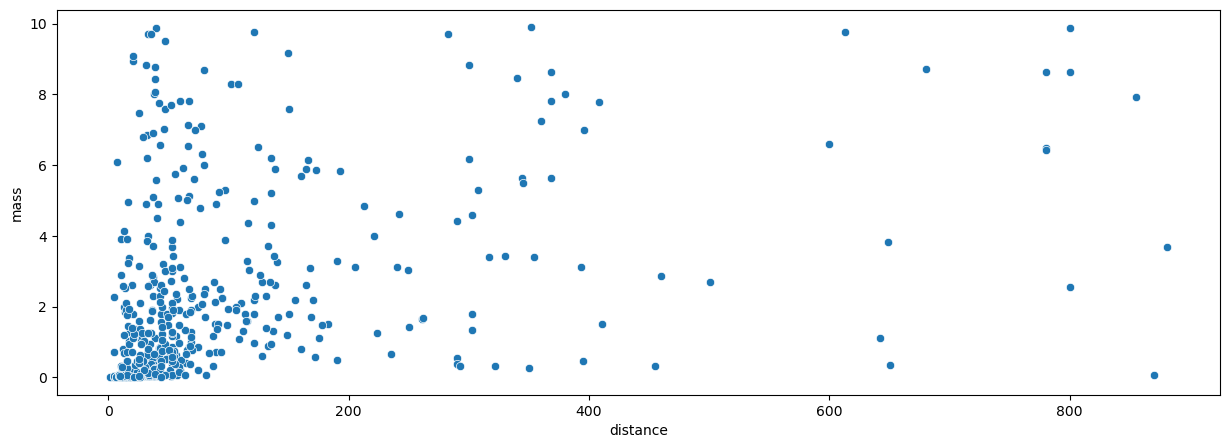

In [21]:
plt.figure(figsize = (15,5))
# Возьмем дистанцию менее 500 и массу менее 10 для наглядности
data = df_pl_perfect [(df_pl_perfect['distance'] < 1000)&(df_pl_perfect['mass'] < 10)]
sns.scatterplot(data = data, x = 'distance', y = 'mass')
# Построим диаграмму зависимости Дистанций и Масс открытых планет
plt.show()

In [22]:
# Вычислим корреляцию между Дистанцией и Массой
df_pl_perfect['distance'].corr(df_pl_perfect['mass'])

0.3727292398553971

##### Точечная диаграмма показывает, что при увеличении дистанции планет от своих звезд, количество планет с маленькой массой заметно уменьшается. На дистанции до 200 прослеживается большое количество планет с маленькой массой, на дистанции более 200 - количество планет с маленькой массой и с большой примерно одинаковое.
##### Расчет корреляции показал, что линейная взаимосвязь Дистанции и Массы немного имеется (значение от 0,3 до 0,6).

### 6) Оценим модель линейной регрессии. Сделаем на ее основе прогноз и вывод по результатам

<Figure size 1500x500 with 0 Axes>

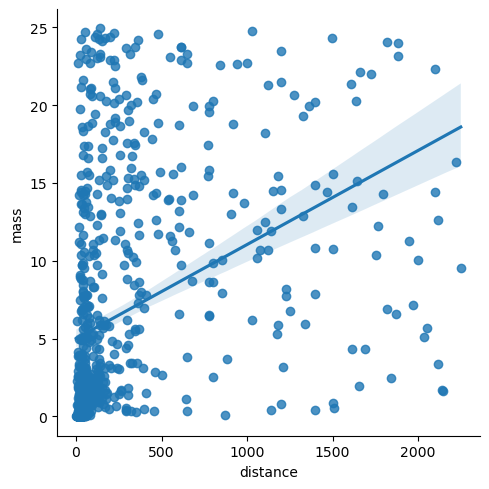

In [23]:
# Создадим графики линейной регрессии
plt.figure(figsize = (15,5)) # тут почему то не работает уширение фигуры((
sns.lmplot(data = df_pl_perfect, x = 'distance', y = 'mass')
plt.show()

##### Прямая линия на графике лучше всего обрисовывает линейную зависимость данных. Синий фон по сторонам линии показывается 95% доверительный интервал.

In [24]:
X = np.array(df_pl_perfect['distance'])
Y = np.array(df_pl_perfect['mass'])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     118.1
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           1.32e-25
Time:                        13:13:16   Log-Likelihood:                -2466.8
No. Observations:                 734   AIC:                             4938.
Df Residuals:                     732   BIC:                             4947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9983      0.302     16.549      0.0

##### Yi = 4.9983 + 0.006*Xi

##### Между Дистанцией и Массой есть ненулевая зависимость. На Массу планет влияют множество параметров, одно из которых - это Дистанция до своей звезды. Её влияение составляет 13,9% от всех совокупных параметров.